# Deep Ensemble learning: Stacking results from deep learning models

# Outline
* **1. Introduction**

    * 1.1 Loading Libraries

* **2. Data preparation**

    * 2.1 Load Data, Metadata, and Preprocess for Each Model
    
    * 2.2 Exploratory Data Analysis
    
    * 2.3 Feature Extraction

* **3. Training & Validating**

    * 3.1 Split Test/Valid dataset
    
    * 3.2 Classifiers
    
    * 3.3 Models Evaluation
    
    * 3.4 Ensemble models

* **4. Testing model's performance**

    * 4.1 Confusion Matrix and Precision-Recall
    
    * 4.2 Results Summary

# **1. Introduction**


### This code is specifically written for [GRAB AI for S.E.A challenge](https://www.aiforsea.com/).

This is a full walkthrough for building the ensemble learning model for car image dataset provided by [AI Stanford University](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). For this competition, I implemented stacked ensemble machine learning, which the outputs from 5 well-known Deep Learning architectures (Inception, Xception, Resnet50, VGG19, and InceptionResnet) are stacked together and used it as the input for new neural networks. You can check more info about stacked ensemble machine learning [HERE](https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/). First, I will prepare the data (Car images), get prediction for each models (InceptionV3, Xception, VGG, Xception, and InceptionResnet), and combine each results from the model and feed the output as an input into final neural networks model.

Special thanks to Hyungsuk Kang from Kaggle for his [Kernel](https://www.kaggle.com/sudosudoohio/eda-deep-learning-ensemble/data) which I adopted some of his code into this code (of course with adjustments).

## 1.1 Loading Libraries

In this comppetition, I used Keras with Tensorflow backend.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Dropout, Lambda, Reshape, Flatten
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import cv2
from keras.applications.inception_v3 import preprocess_input as inception_v3_pre
from keras.applications.resnet50 import preprocess_input as resnet50_pre
from keras.applications.vgg19 import preprocess_input as vgg19_pre
from keras.applications.xception import preprocess_input as xception_pre
from keras.applications.inception_resnet_v2 import preprocess_input as InceptionResNetV2_pre
from keras.models import load_model

import matplotlib.image as mpimg
import seaborn as sns
from scipy.io import loadmat
np.random.seed(2)

Using TensorFlow backend.


# 2. Data Preparation

## 2.1. Load Data, Metadata, and Preprocess data for Each Model

Each model requires certain image pixel size and  image diferent preprocesses

### Set up file links and metadata

In [2]:
# Setup Input folder link and image sizes
from pathlib import Path

folder = 'input/'
devkit_path = Path(folder + 'devkit/')
cars_meta = loadmat(devkit_path/'cars_meta.mat')
train_path = folder + 'cars_train/'
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
test_path = folder + 'cars_test/'
cars_test_annos = loadmat(devkit_path/'cars_test_annos_withlabels.mat')

img_path = folder
im_width = 299
im_heigth = 299
im_chan = 3

In [3]:
# Retreiving Class ids and names

frame1 = [[i.flat[0] for i in line] for line in cars_meta['class_names'][0]]
columns1 = ['names']
df_train1 = pd.DataFrame(frame1, columns=columns1)
df_train1.head()
df_train1.tail()

,names
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007
195,smart fortwo Convertible 2012


### Set up metadata for Training set

In [4]:
# Setup Train set dataframe of metadata with necessary information. Since this code focus on classification, the bounding boxes are excluded.

class_id = []

frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class_id'] = df_train['class_id']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path + f for f in df_train['fname']] #  Appending Path

for i in range (len(df_train['class_id'])):
    f = df_train['class_id'][i]
    class_id.append(df_train1['names'][f])


df_train['class_name'] = [class_id][0]
df_train = df_train.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_train.head()

,class_id,fname,class_name
0,13,input/cars_train/00001.jpg,Audi TTS Coupe 2012
1,2,input/cars_train/00002.jpg,Acura TL Sedan 2012
2,90,input/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,133,input/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,105,input/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


### Set up metadata for Test set

In [5]:
class_id1 = []

frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['class_id'] = df_test['class_id']-1 # Python indexing starts on zero.
df_test['fname'] = [test_path + f for f in df_test['fname']] #  Appending Path

for i in range (len(df_test['class_id'])):
    f = df_test['class_id'][i]
    class_id1.append(df_train1['names'][f])


df_test['class_name'] = [class_id1][0]
df_test = df_test.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'], axis = 1) ## Deleting unnecessary infomations
df_test.head()

,class_id,fname,class_name
0,180,input/cars_test/00001.jpg,Suzuki Aerio Sedan 2007
1,102,input/cars_test/00002.jpg,Ferrari 458 Italia Convertible 2012
2,144,input/cars_test/00003.jpg,Jeep Patriot SUV 2012
3,186,input/cars_test/00004.jpg,Toyota Camry Sedan 2012
4,184,input/cars_test/00005.jpg,Tesla Model S Sedan 2012


### Load Training Images

In [6]:
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from tqdm import tqdm_notebook , tnrange
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.transform import resize

In [7]:
x_imgs = np.zeros((len(df_train), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs = np.zeros((len(df_train), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_train['fname']), total=len(df_train['fname'])):
    imgs = load_img(df_train['fname'][n])
    imgs = img_to_array(imgs)
    imgs = resize(imgs, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True, anti_aliasing=True)
    x_imgs[n] = imgs
    
    y_imgs[n] = np.int(df_train['class_id'][n])

## Checking if we load the right data.

In [22]:
def get_images(length, df, imgs):

    rand= np.random.randint(0,length,4)

    fig=plt.figure(figsize=(15, 15))
    columns = 2
    rows = 2
    for i in range(1, columns*rows +1):
        r = rand[i-1]
        img = imgs[r]
        cla_name = df['class_name'][r]
        fig.add_subplot(rows, columns, i)
        plt.title(cla_name)
        plt.imshow(img)

    plt.show()

### Displaying random Train images

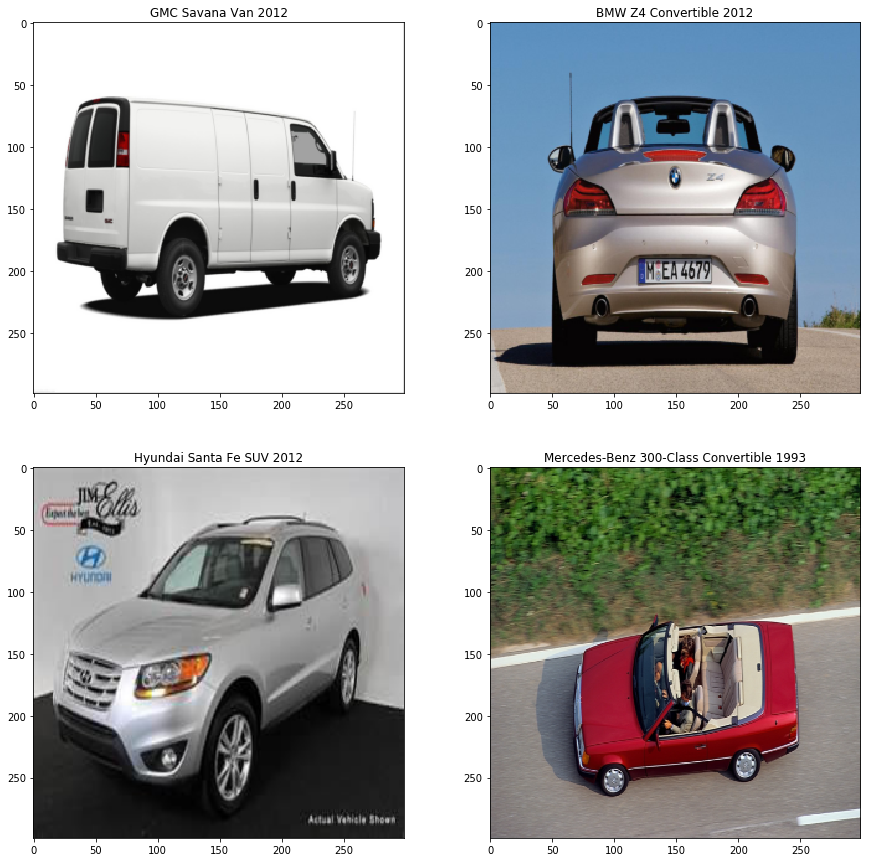

In [23]:
len_train = x_imgs.shape[0]
get_images(len_train, df_train, x_imgs)

### Load Test Images

In [10]:
x_imgs1 = np.zeros((len(df_test), im_heigth, im_width, im_chan), dtype=np.uint8)
y_imgs1 = np.zeros((len(df_test), 1), dtype=np.uint8)

for n, id_ in tqdm_notebook(enumerate(df_test['fname']), total=len(df_test['fname'])):
    imgs1 = load_img(df_test['fname'][n])
    imgs1 = img_to_array(imgs1)
    imgs1 = resize(imgs1, (im_width, im_heigth, im_chan), mode='constant', preserve_range=True, anti_aliasing=True)
    x_imgs1[n] = imgs1
    
    y_imgs1[n] = np.int(df_test['class_id'][n])

In [11]:
print("test set x shape :", x_imgs1.shape)
print("test set y shape :", y_imgs1.shape)

test set x shape : (8041, 299, 299, 3)
test set y shape : (8041, 1)


### Displaying random Test images

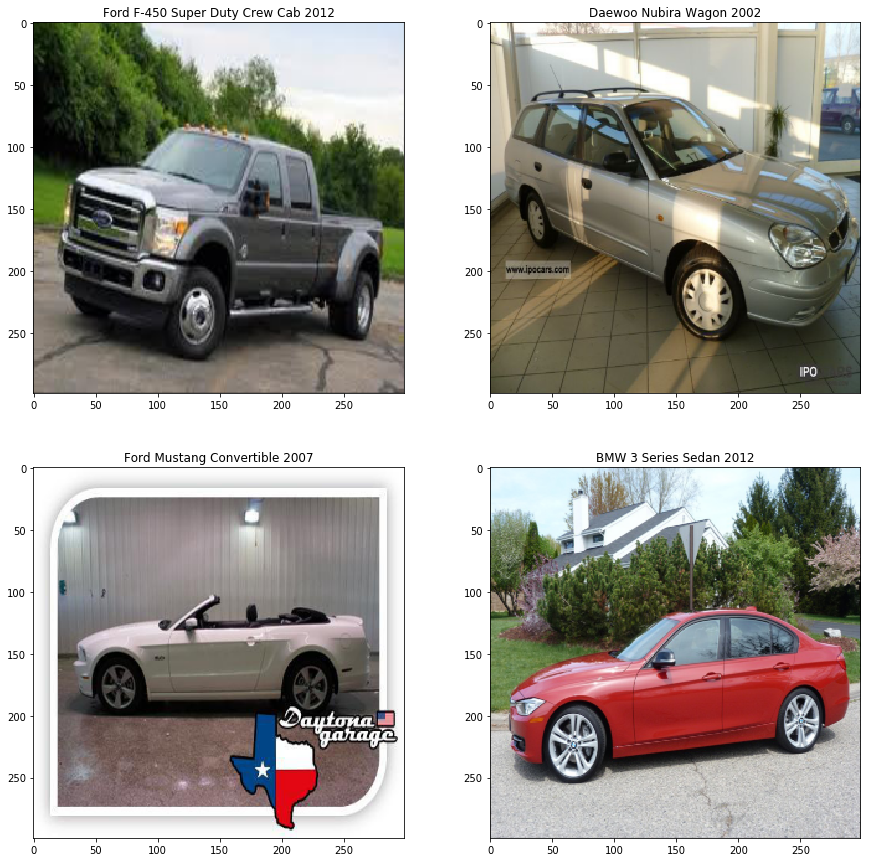

In [24]:
len_test = x_imgs1.shape[0]
get_images(len_test, df_test, x_imgs1)

## 2.2 Exploratory Data Analysis

### Distribution of Output Variable

In [27]:
# Checking the class frequency

freq_labels = df_train.groupby('class_name').count()[['class_id']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='class_id', ascending=False)
freq_labels.head(10)

,class_id
class_name,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47
Chevrolet Corvette ZR1 2012,47
Audi S6 Sedan 2011,46
Volkswagen Golf Hatchback 1991,46
Ford GT Coupe 2006,46


In [28]:
freq_labels.to_csv(r'cars_count.csv', header = True)

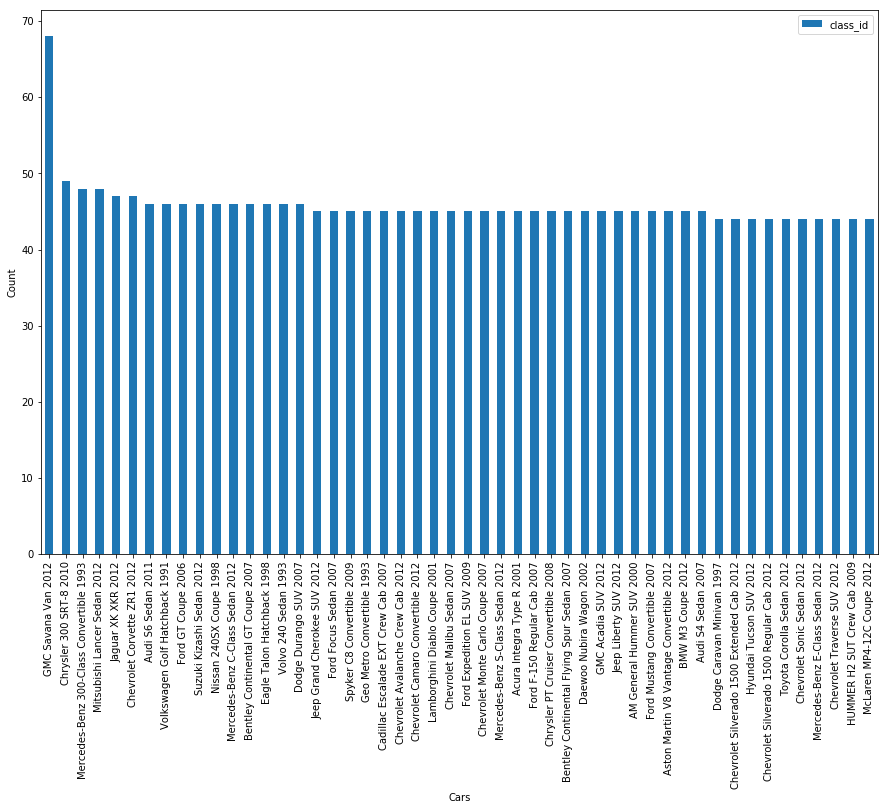

In [29]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");

In [30]:
from collections import Counter

print('The data set is imbalanced: {}'.format(Counter(df_train['class_id'])))

The data set is imbalanced: Counter({118: 68, 78: 49, 166: 48, 160: 48, 143: 47, 55: 47, 193: 46, 190: 46, 42: 46, 19: 46, 111: 46, 161: 46, 170: 46, 181: 46, 97: 46, 94: 46, 122: 45, 72: 45, 147: 45, 52: 45, 43: 45, 64: 45, 113: 45, 7: 45, 58: 45, 164: 45, 120: 45, 146: 45, 108: 45, 178: 45, 23: 45, 0: 45, 5: 45, 71: 45, 106: 45, 152: 45, 114: 45, 80: 45, 33: 45, 81: 45, 88: 44, 57: 44, 84: 44, 171: 44, 169: 44, 104: 44, 176: 44, 172: 44, 186: 44, 93: 44, 187: 44, 144: 44, 73: 44, 136: 44, 75: 44, 107: 44, 124: 44, 159: 44, 15: 44, 62: 44, 131: 44, 30: 44, 45: 44, 150: 44, 86: 44, 74: 44, 163: 44, 13: 43, 2: 43, 191: 43, 119: 43, 85: 43, 179: 43, 153: 43, 138: 43, 103: 43, 14: 43, 189: 43, 28: 43, 109: 43, 17: 43, 50: 43, 60: 43, 154: 43, 148: 43, 47: 43, 194: 43, 21: 43, 112: 43, 116: 43, 69: 43, 145: 43, 79: 43, 105: 42, 134: 42, 192: 42, 65: 42, 132: 42, 96: 42, 100: 42, 110: 42, 125: 42, 130: 42, 177: 42, 139: 42, 29: 42, 49: 42, 182: 42, 83: 42, 167: 42, 20: 42, 31: 42, 3: 42, 11

It can be seen that:
    
    - Label samples are biased to some labels.
    - Balancing weight for each class may improve LB score.

In [13]:
from sklearn.utils.class_weight import compute_class_weight

#y_integers = np.argmax(y_train1, axis=1)
class_weights = compute_class_weight('balanced', np.unique(df_train['class_id']), df_train['class_id'])
class_weights = dict(enumerate(class_weights))

## 2.3 Feature Extraction

### Extract Bottleneck Features for Train and Test Data


As metioned before, every model have their own types of data. Therefore, different data are created for each model.
Function from [Yang Peiwan's kernel](https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47) with modifications:

In [28]:
def get_features(MODEL, data, batch_size, preprocess):
    
    cnn_model = MODEL(include_top=False, input_shape=(im_width, im_heigth, im_chan), weights='imagenet')
    
    inputs = Input((im_width, im_heigth, im_chan))
    x = inputs
    x = Lambda(preprocess, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=batch_size, verbose=0)
    return features### InceptionV3

### InceptionV3

In [25]:
inception_train_features = get_features(InceptionV3, x_imgs, 32, inception_v3_pre)
inception_test_features = get_features(InceptionV3, x_imgs1, 32, inception_v3_pre)

8041/8041 [==============================] - ETA: 18:3 - ETA: 9:4 - ETA: 6: - ETA: 5: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - E

### Xception

In [26]:
xception_train_features = get_features(Xception, x_imgs, 32, xception_pre)
xception_test_features = get_features(Xception, x_imgs1, 32, xception_pre)

8041/8041 [==============================] - ETA: 19:5 - ETA: 10:4 - ETA: 7:4 - ETA: 6: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - 

### Resnet50

In [29]:
resnet_train_features = get_features(ResNet50, x_imgs, 32, resnet50_pre)
resnet_test_features = get_features(ResNet50, x_imgs1, 32, resnet50_pre)

C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\faizm\Anaconda3\envs\faiz-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### InceptionResNetV2

In [30]:
inceptionresnet_train_features = get_features(InceptionResNetV2, x_imgs, 32, InceptionResNetV2_pre)
inceptionresnet_test_features = get_features(InceptionResNetV2, x_imgs1, 32, InceptionResNetV2_pre)

### VGG19

In [31]:
vgg_train_features = get_features(VGG19, x_imgs, 32, vgg19_pre)
vgg_test_features = get_features(VGG19, x_imgs1, 32, vgg19_pre)

# 3. Training/Validating Pipeline

## 3.1. Split Test/Valid dataset

### Split test data for model validation and testing, with 40% validation and 60% testing

In [32]:
from keras.utils import to_categorical

y_train = to_categorical(df_train['class_id'])
y_test = to_categorical(df_test['class_id'])

In [33]:
X_valid_xception, X_test_xception, y_valid_xception, y_test_xception =  train_test_split(xception_test_features, y_test, test_size=0.6, random_state=99)
X_valid_inception, X_test_inception, y_valid_inception, y_test_inception = train_test_split(inception_test_features, y_test, test_size=0.6, random_state=99)
X_valid_vgg, X_test_vgg, y_valid_vgg, y_test_vgg = train_test_split(vgg_test_features, y_test, test_size=0.6, random_state=99)
X_valid_resnet, X_test_resnet, y_valid_resnet, y_test_resnet = train_test_split(resnet_test_features, y_test, test_size=0.6, random_state=99)
X_valid_inceptionresnet, X_test_inceptionresnet, y_valid_inceptionresnet, y_test_inceptionresnet = train_test_split(inceptionresnet_test_features, y_test, test_size=0.6, random_state=99)

In [34]:
print("x train shape :", inception_train_features.shape[0])
print("x valid shape :", X_valid_xception.shape[0])
print("x test shape :", X_test_xception.shape[0])
print("y train shape :", y_train.shape[0])
print("y valid shape :", y_valid_xception.shape[0])
print("y train shape :", y_test_xception.shape[0])

x train shape : 8144
x valid shape : 3216
x test shape : 4825
y train shape : 8144
y valid shape : 3216
y train shape : 4825


## If you want to Test the trained model, skip 3.2 and move to 3.4

Since I provided the trained model for all Inception, Xception, VGG19, Resnet50, InceptionResnet, and the Ensemble Model. You can skip this part. All the save model are in folder save_models

## 3.2. Classifiers


### Neural Net

In [35]:
n_class = 196

Inception_model = Sequential()
Inception_model.add(Dense(512, activation='relu', input_shape=inception_train_features.shape[1:]))
Inception_model.add(Dropout(0.2))
Inception_model.add(Dense(n_class, activation='softmax'))

Inception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Inception_model.summary()


Xception_model = Sequential()
Xception_model.add(Dense(512, activation='relu', input_shape=xception_train_features.shape[1:]))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(n_class, activation='softmax'))

Xception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Xception_model.summary()


VGG_model = Sequential()
VGG_model.add(Dense(512, activation='relu', input_shape=vgg_train_features.shape[1:]))
VGG_model.add(Dropout(0.2))
VGG_model.add(Dense(n_class, activation='softmax'))

VGG_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'], 
           )

VGG_model.summary()

Resnet_model = Sequential()
Resnet_model.add(Dense(512, activation='relu', input_shape=resnet_train_features.shape[1:]))
Resnet_model.add(Dropout(0.2))
Resnet_model.add(Dense(n_class, activation='softmax'))

Resnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

Resnet_model.summary()

InceptionResnet_model = Sequential()
InceptionResnet_model.add(Dense(512, activation='relu', input_shape=inceptionresnet_train_features.shape[1:]))
InceptionResnet_model.add(Dropout(0.2))
InceptionResnet_model.add(Dense(n_class, activation='softmax'))

InceptionResnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

InceptionResnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               100548    
Total params: 1,149,636
Trainable params: 1,149,636
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________


### Callbacks

- ModelCheckpoint is used to get the best model after epochs

- ReduceLROnPlateau is used to manipulate learning rate for more delciate correction

- EarlyStopping stop the model if there is no improvement to validation loss. This is to avoid model overfit and wasting time.

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode = 'min',factor=0.5, patience=50, min_lr=0.00001, verbose=1)

inception_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/inception.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                     early_stopping
                     ]

xception_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                      ModelCheckpoint(filepath='saved_models/xception.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                    early_stopping
                     ]

resnet_callbacks=[TQDMNotebookCallback(),
                    reduce_lr,
                    ModelCheckpoint(filepath='saved_models/resnet.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                  early_stopping
                     ]

vgg_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/vgg.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
               early_stopping
                     ]

inceptionresnet_callbacks=[TQDMNotebookCallback(),
                reduce_lr,
                ModelCheckpoint(filepath='saved_models/inceptionresnet.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
               early_stopping
                     ]

In [39]:
epochs = 1000 # Increase this if you want more accurate results(It is recommended to run on personal computer in this case)

inception_history = Inception_model.fit(inception_train_features, y_train, 
          validation_data=(X_valid_inception, y_valid_inception),
          epochs=epochs, 
          callbacks=inception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

xception_history = Xception_model.fit(xception_train_features, y_train, 
          validation_data=(X_valid_xception, y_valid_xception),
          epochs=epochs,                            
          callbacks=xception_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

resnet_history = Resnet_model.fit(resnet_train_features, y_train, 
          validation_data=(X_valid_resnet, y_valid_resnet),
          epochs=epochs, 
          callbacks=resnet_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

vgg_history = VGG_model.fit(vgg_train_features, y_train, 
          validation_data=(X_valid_vgg, y_valid_vgg),
          epochs=epochs, 
          callbacks=vgg_callbacks,
          class_weight=class_weights,
          batch_size=32, verbose=0)

inceptionresnet_history = InceptionResnet_model.fit(inceptionresnet_train_features, y_train, 
                        validation_data=(X_valid_inceptionresnet, y_valid_inceptionresnet),
                        epochs=epochs, 
                        callbacks=inceptionresnet_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=0)


Epoch 00001: val_loss improved from inf to 3.69807, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.69807 to 3.27533, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.27533 to 3.00856, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00004: val_loss improved from 3.00856 to 2.82196, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.82196 to 2.73305, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.73305 to 2.60030, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.60030 to 2.50199, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.50199 to 2.41814, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.41814 to 2.38605, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.38605 to 2.33905, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00011: val_loss improved from 2.33905 to 2.29069, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00012: val_loss improved from 2.29069 to 2.23760, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00013: val_loss did not improve from 2.23760



Epoch 00014: val_loss did not improve from 2.23760



Epoch 00015: val_loss improved from 2.23760 to 2.18959, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00016: val_loss did not improve from 2.18959



Epoch 00017: val_loss did not improve from 2.18959



Epoch 00018: val_loss did not improve from 2.18959



Epoch 00019: val_loss did not improve from 2.18959



Epoch 00020: val_loss improved from 2.18959 to 2.18255, saving model to saved_models/inception.best.from_features.hdf5



Epoch 00021: val_loss did not improve from 2.18255



Epoch 00022: val_loss did not improve from 2.18255



Epoch 00023: val_loss did not improve from 2.18255



Epoch 00024: val_loss did not improve from 2.18255



Epoch 00025: val_loss did not improve from 2.18255



Epoch 00026: val_loss did not improve from 2.18255



Epoch 00027: val_loss did not improve from 2.18255



Epoch 00028: val_loss did not improve from 2.18255



Epoch 00029: val_loss did not improve from 2.18255



Epoch 00030: val_loss did not improve from 2.18255



Epoch 00031: val_loss did not improve from 2.18255



Epoch 00032: val_loss did not improve from 2.18255



Epoch 00033: val_loss did not improve from 2.18255



Epoch 00034: val_loss did not improve from 2.18255



Epoch 00035: val_loss did not improve from 2.18255



Epoch 00036: val_loss did not improve from 2.18255



Epoch 00037: val_loss did not improve from 2.18255



Epoch 00038: val_loss did not improve from 2.18255



Epoch 00039: val_loss did not improve from 2.18255



Epoch 00040: val_loss did not improve from 2.18255



Epoch 00041: val_loss did not improve from 2.18255



Epoch 00042: val_loss did not improve from 2.18255



Epoch 00043: val_loss did not improve from 2.18255



Epoch 00044: val_loss did not improve from 2.18255



Epoch 00045: val_loss did not improve from 2.18255



Epoch 00046: val_loss did not improve from 2.18255



Epoch 00047: val_loss did not improve from 2.18255



Epoch 00048: val_loss did not improve from 2.18255



Epoch 00049: val_loss did not improve from 2.18255



Epoch 00050: val_loss did not improve from 2.18255



Epoch 00051: val_loss did not improve from 2.18255



Epoch 00052: val_loss did not improve from 2.18255



Epoch 00053: val_loss did not improve from 2.18255



Epoch 00054: val_loss did not improve from 2.18255



Epoch 00055: val_loss did not improve from 2.18255



Epoch 00056: val_loss did not improve from 2.18255



Epoch 00057: val_loss did not improve from 2.18255



Epoch 00058: val_loss did not improve from 2.18255



Epoch 00059: val_loss did not improve from 2.18255



Epoch 00060: val_loss did not improve from 2.18255



Epoch 00061: val_loss did not improve from 2.18255



Epoch 00062: val_loss did not improve from 2.18255



Epoch 00063: val_loss did not improve from 2.18255



Epoch 00064: val_loss did not improve from 2.18255



Epoch 00065: val_loss did not improve from 2.18255



Epoch 00066: val_loss did not improve from 2.18255



Epoch 00067: val_loss did not improve from 2.18255



Epoch 00068: val_loss did not improve from 2.18255



Epoch 00069: val_loss did not improve from 2.18255



Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00070: val_loss did not improve from 2.18255



Epoch 00071: val_loss did not improve from 2.18255



Epoch 00072: val_loss did not improve from 2.18255



Epoch 00073: val_loss did not improve from 2.18255



Epoch 00074: val_loss did not improve from 2.18255



Epoch 00075: val_loss did not improve from 2.18255



Epoch 00076: val_loss did not improve from 2.18255



Epoch 00077: val_loss did not improve from 2.18255



Epoch 00078: val_loss did not improve from 2.18255



Epoch 00079: val_loss did not improve from 2.18255



Epoch 00080: val_loss did not improve from 2.18255



Epoch 00081: val_loss did not improve from 2.18255



Epoch 00082: val_loss did not improve from 2.18255



Epoch 00083: val_loss did not improve from 2.18255



Epoch 00084: val_loss did not improve from 2.18255



Epoch 00085: val_loss did not improve from 2.18255



Epoch 00086: val_loss did not improve from 2.18255



Epoch 00087: val_loss did not improve from 2.18255



Epoch 00088: val_loss did not improve from 2.18255



Epoch 00089: val_loss did not improve from 2.18255



Epoch 00090: val_loss did not improve from 2.18255



Epoch 00091: val_loss did not improve from 2.18255



Epoch 00092: val_loss did not improve from 2.18255



Epoch 00093: val_loss did not improve from 2.18255



Epoch 00094: val_loss did not improve from 2.18255



Epoch 00095: val_loss did not improve from 2.18255



Epoch 00096: val_loss did not improve from 2.18255



Epoch 00097: val_loss did not improve from 2.18255



Epoch 00098: val_loss did not improve from 2.18255



Epoch 00099: val_loss did not improve from 2.18255



Epoch 00100: val_loss did not improve from 2.18255



Epoch 00101: val_loss did not improve from 2.18255



Epoch 00102: val_loss did not improve from 2.18255



Epoch 00103: val_loss did not improve from 2.18255



Epoch 00104: val_loss did not improve from 2.18255



Epoch 00105: val_loss did not improve from 2.18255



Epoch 00106: val_loss did not improve from 2.18255



Epoch 00107: val_loss did not improve from 2.18255



Epoch 00108: val_loss did not improve from 2.18255



Epoch 00109: val_loss did not improve from 2.18255



Epoch 00110: val_loss did not improve from 2.18255



Epoch 00111: val_loss did not improve from 2.18255



Epoch 00112: val_loss did not improve from 2.18255



Epoch 00113: val_loss did not improve from 2.18255



Epoch 00114: val_loss did not improve from 2.18255



Epoch 00115: val_loss did not improve from 2.18255



Epoch 00116: val_loss did not improve from 2.18255



Epoch 00117: val_loss did not improve from 2.18255



Epoch 00118: val_loss did not improve from 2.18255



Epoch 00119: val_loss did not improve from 2.18255



Epoch 00120: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00120: val_loss did not improve from 2.18255

Epoch 00120: early stopping



Epoch 00001: val_loss improved from inf to 3.39980, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.39980 to 2.96889, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00003: val_loss improved from 2.96889 to 2.71512, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.71512 to 2.55665, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.55665 to 2.45645, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.45645 to 2.36852, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.36852 to 2.30473, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.30473 to 2.23442, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.23442 to 2.19056, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.19056 to 2.13146, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00011: val_loss improved from 2.13146 to 2.11265, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00012: val_loss did not improve from 2.11265



Epoch 00013: val_loss did not improve from 2.11265



Epoch 00014: val_loss improved from 2.11265 to 2.10284, saving model to saved_models/xception.best.from_features.hdf5



Epoch 00015: val_loss did not improve from 2.10284



Epoch 00016: val_loss did not improve from 2.10284



Epoch 00017: val_loss did not improve from 2.10284



Epoch 00018: val_loss did not improve from 2.10284



Epoch 00019: val_loss did not improve from 2.10284



Epoch 00020: val_loss did not improve from 2.10284



Epoch 00021: val_loss did not improve from 2.10284



Epoch 00022: val_loss did not improve from 2.10284



Epoch 00023: val_loss did not improve from 2.10284



Epoch 00024: val_loss did not improve from 2.10284



Epoch 00025: val_loss did not improve from 2.10284



Epoch 00026: val_loss did not improve from 2.10284



Epoch 00027: val_loss did not improve from 2.10284



Epoch 00028: val_loss did not improve from 2.10284



Epoch 00029: val_loss did not improve from 2.10284



Epoch 00030: val_loss did not improve from 2.10284



Epoch 00031: val_loss did not improve from 2.10284



Epoch 00032: val_loss did not improve from 2.10284



Epoch 00033: val_loss did not improve from 2.10284



Epoch 00034: val_loss did not improve from 2.10284



Epoch 00035: val_loss did not improve from 2.10284



Epoch 00036: val_loss did not improve from 2.10284



Epoch 00037: val_loss did not improve from 2.10284



Epoch 00038: val_loss did not improve from 2.10284



Epoch 00039: val_loss did not improve from 2.10284



Epoch 00040: val_loss did not improve from 2.10284



Epoch 00041: val_loss did not improve from 2.10284



Epoch 00042: val_loss did not improve from 2.10284



Epoch 00043: val_loss did not improve from 2.10284



Epoch 00044: val_loss did not improve from 2.10284



Epoch 00045: val_loss did not improve from 2.10284



Epoch 00046: val_loss did not improve from 2.10284



Epoch 00047: val_loss did not improve from 2.10284



Epoch 00048: val_loss did not improve from 2.10284



Epoch 00049: val_loss did not improve from 2.10284



Epoch 00050: val_loss did not improve from 2.10284



Epoch 00051: val_loss did not improve from 2.10284



Epoch 00052: val_loss did not improve from 2.10284



Epoch 00053: val_loss did not improve from 2.10284



Epoch 00054: val_loss did not improve from 2.10284



Epoch 00055: val_loss did not improve from 2.10284



Epoch 00056: val_loss did not improve from 2.10284



Epoch 00057: val_loss did not improve from 2.10284



Epoch 00058: val_loss did not improve from 2.10284



Epoch 00059: val_loss did not improve from 2.10284



Epoch 00060: val_loss did not improve from 2.10284



Epoch 00061: val_loss did not improve from 2.10284



Epoch 00062: val_loss did not improve from 2.10284



Epoch 00063: val_loss did not improve from 2.10284



Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00064: val_loss did not improve from 2.10284



Epoch 00065: val_loss did not improve from 2.10284



Epoch 00066: val_loss did not improve from 2.10284



Epoch 00067: val_loss did not improve from 2.10284



Epoch 00068: val_loss did not improve from 2.10284



Epoch 00069: val_loss did not improve from 2.10284



Epoch 00070: val_loss did not improve from 2.10284



Epoch 00071: val_loss did not improve from 2.10284



Epoch 00072: val_loss did not improve from 2.10284



Epoch 00073: val_loss did not improve from 2.10284



Epoch 00074: val_loss did not improve from 2.10284



Epoch 00075: val_loss did not improve from 2.10284



Epoch 00076: val_loss did not improve from 2.10284



Epoch 00077: val_loss did not improve from 2.10284



Epoch 00078: val_loss did not improve from 2.10284



Epoch 00079: val_loss did not improve from 2.10284



Epoch 00080: val_loss did not improve from 2.10284



Epoch 00081: val_loss did not improve from 2.10284



Epoch 00082: val_loss did not improve from 2.10284



Epoch 00083: val_loss did not improve from 2.10284



Epoch 00084: val_loss did not improve from 2.10284



Epoch 00085: val_loss did not improve from 2.10284



Epoch 00086: val_loss did not improve from 2.10284



Epoch 00087: val_loss did not improve from 2.10284



Epoch 00088: val_loss did not improve from 2.10284



Epoch 00089: val_loss did not improve from 2.10284



Epoch 00090: val_loss did not improve from 2.10284



Epoch 00091: val_loss did not improve from 2.10284



Epoch 00092: val_loss did not improve from 2.10284



Epoch 00093: val_loss did not improve from 2.10284



Epoch 00094: val_loss did not improve from 2.10284



Epoch 00095: val_loss did not improve from 2.10284



Epoch 00096: val_loss did not improve from 2.10284



Epoch 00097: val_loss did not improve from 2.10284



Epoch 00098: val_loss did not improve from 2.10284



Epoch 00099: val_loss did not improve from 2.10284



Epoch 00100: val_loss did not improve from 2.10284



Epoch 00101: val_loss did not improve from 2.10284



Epoch 00102: val_loss did not improve from 2.10284



Epoch 00103: val_loss did not improve from 2.10284



Epoch 00104: val_loss did not improve from 2.10284



Epoch 00105: val_loss did not improve from 2.10284



Epoch 00106: val_loss did not improve from 2.10284



Epoch 00107: val_loss did not improve from 2.10284



Epoch 00108: val_loss did not improve from 2.10284



Epoch 00109: val_loss did not improve from 2.10284



Epoch 00110: val_loss did not improve from 2.10284



Epoch 00111: val_loss did not improve from 2.10284



Epoch 00112: val_loss did not improve from 2.10284



Epoch 00113: val_loss did not improve from 2.10284



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00114: val_loss did not improve from 2.10284

Epoch 00114: early stopping



Epoch 00001: val_loss improved from inf to 3.79868, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.79868 to 3.15688, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.15688 to 2.67804, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.67804 to 2.41401, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.41401 to 2.19046, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.19046 to 2.06261, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.06261 to 2.04133, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.04133 to 1.88271, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00009: val_loss improved from 1.88271 to 1.82995, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00010: val_loss improved from 1.82995 to 1.81062, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00011: val_loss improved from 1.81062 to 1.80864, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00012: val_loss improved from 1.80864 to 1.77311, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00013: val_loss improved from 1.77311 to 1.70833, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00014: val_loss did not improve from 1.70833



Epoch 00015: val_loss did not improve from 1.70833



Epoch 00016: val_loss improved from 1.70833 to 1.70237, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00017: val_loss did not improve from 1.70237



Epoch 00018: val_loss improved from 1.70237 to 1.68242, saving model to saved_models/resnet.best.from_features.hdf5



Epoch 00019: val_loss did not improve from 1.68242



Epoch 00020: val_loss did not improve from 1.68242



Epoch 00021: val_loss did not improve from 1.68242



Epoch 00022: val_loss did not improve from 1.68242



Epoch 00023: val_loss did not improve from 1.68242



Epoch 00024: val_loss did not improve from 1.68242



Epoch 00025: val_loss did not improve from 1.68242



Epoch 00026: val_loss did not improve from 1.68242



Epoch 00027: val_loss did not improve from 1.68242



Epoch 00028: val_loss did not improve from 1.68242



Epoch 00029: val_loss did not improve from 1.68242



Epoch 00030: val_loss did not improve from 1.68242



Epoch 00031: val_loss did not improve from 1.68242



Epoch 00032: val_loss did not improve from 1.68242



Epoch 00033: val_loss did not improve from 1.68242



Epoch 00034: val_loss did not improve from 1.68242



Epoch 00035: val_loss did not improve from 1.68242



Epoch 00036: val_loss did not improve from 1.68242



Epoch 00037: val_loss did not improve from 1.68242



Epoch 00038: val_loss did not improve from 1.68242



Epoch 00039: val_loss did not improve from 1.68242



Epoch 00040: val_loss did not improve from 1.68242



Epoch 00041: val_loss did not improve from 1.68242



Epoch 00042: val_loss did not improve from 1.68242



Epoch 00043: val_loss did not improve from 1.68242



Epoch 00044: val_loss did not improve from 1.68242



Epoch 00045: val_loss did not improve from 1.68242



Epoch 00046: val_loss did not improve from 1.68242



Epoch 00047: val_loss did not improve from 1.68242



Epoch 00048: val_loss did not improve from 1.68242



Epoch 00049: val_loss did not improve from 1.68242



Epoch 00050: val_loss did not improve from 1.68242



Epoch 00051: val_loss did not improve from 1.68242



Epoch 00052: val_loss did not improve from 1.68242



Epoch 00053: val_loss did not improve from 1.68242



Epoch 00054: val_loss did not improve from 1.68242



Epoch 00055: val_loss did not improve from 1.68242



Epoch 00056: val_loss did not improve from 1.68242



Epoch 00057: val_loss did not improve from 1.68242



Epoch 00058: val_loss did not improve from 1.68242



Epoch 00059: val_loss did not improve from 1.68242



Epoch 00060: val_loss did not improve from 1.68242



Epoch 00061: val_loss did not improve from 1.68242



Epoch 00062: val_loss did not improve from 1.68242



Epoch 00063: val_loss did not improve from 1.68242



Epoch 00064: val_loss did not improve from 1.68242



Epoch 00065: val_loss did not improve from 1.68242



Epoch 00066: val_loss did not improve from 1.68242



Epoch 00067: val_loss did not improve from 1.68242



Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00068: val_loss did not improve from 1.68242



Epoch 00069: val_loss did not improve from 1.68242



Epoch 00070: val_loss did not improve from 1.68242



Epoch 00071: val_loss did not improve from 1.68242



Epoch 00072: val_loss did not improve from 1.68242



Epoch 00073: val_loss did not improve from 1.68242



Epoch 00074: val_loss did not improve from 1.68242



Epoch 00075: val_loss did not improve from 1.68242



Epoch 00076: val_loss did not improve from 1.68242



Epoch 00077: val_loss did not improve from 1.68242



Epoch 00078: val_loss did not improve from 1.68242



Epoch 00079: val_loss did not improve from 1.68242



Epoch 00080: val_loss did not improve from 1.68242



Epoch 00081: val_loss did not improve from 1.68242



Epoch 00082: val_loss did not improve from 1.68242



Epoch 00083: val_loss did not improve from 1.68242



Epoch 00084: val_loss did not improve from 1.68242



Epoch 00085: val_loss did not improve from 1.68242



Epoch 00086: val_loss did not improve from 1.68242



Epoch 00087: val_loss did not improve from 1.68242



Epoch 00088: val_loss did not improve from 1.68242



Epoch 00089: val_loss did not improve from 1.68242



Epoch 00090: val_loss did not improve from 1.68242



Epoch 00091: val_loss did not improve from 1.68242



Epoch 00092: val_loss did not improve from 1.68242



Epoch 00093: val_loss did not improve from 1.68242



Epoch 00094: val_loss did not improve from 1.68242



Epoch 00095: val_loss did not improve from 1.68242



Epoch 00096: val_loss did not improve from 1.68242



Epoch 00097: val_loss did not improve from 1.68242



Epoch 00098: val_loss did not improve from 1.68242



Epoch 00099: val_loss did not improve from 1.68242



Epoch 00100: val_loss did not improve from 1.68242



Epoch 00101: val_loss did not improve from 1.68242



Epoch 00102: val_loss did not improve from 1.68242



Epoch 00103: val_loss did not improve from 1.68242



Epoch 00104: val_loss did not improve from 1.68242



Epoch 00105: val_loss did not improve from 1.68242



Epoch 00106: val_loss did not improve from 1.68242



Epoch 00107: val_loss did not improve from 1.68242



Epoch 00108: val_loss did not improve from 1.68242



Epoch 00109: val_loss did not improve from 1.68242



Epoch 00110: val_loss did not improve from 1.68242



Epoch 00111: val_loss did not improve from 1.68242



Epoch 00112: val_loss did not improve from 1.68242



Epoch 00113: val_loss did not improve from 1.68242



Epoch 00114: val_loss did not improve from 1.68242



Epoch 00115: val_loss did not improve from 1.68242



Epoch 00116: val_loss did not improve from 1.68242



Epoch 00117: val_loss did not improve from 1.68242



Epoch 00118: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00118: val_loss did not improve from 1.68242

Epoch 00118: early stopping



Epoch 00001: val_loss improved from inf to 3.75562, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.75562 to 2.94745, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00003: val_loss improved from 2.94745 to 2.57153, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00004: val_loss improved from 2.57153 to 2.23879, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.23879 to 2.21612, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.21612 to 2.11226, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.11226 to 2.06529, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.06529 to 2.02739, saving model to saved_models/vgg.best.from_features.hdf5



Epoch 00009: val_loss did not improve from 2.02739



Epoch 00010: val_loss did not improve from 2.02739



Epoch 00011: val_loss did not improve from 2.02739



Epoch 00012: val_loss did not improve from 2.02739



Epoch 00013: val_loss did not improve from 2.02739



Epoch 00014: val_loss did not improve from 2.02739



Epoch 00015: val_loss did not improve from 2.02739



Epoch 00016: val_loss did not improve from 2.02739



Epoch 00017: val_loss did not improve from 2.02739



Epoch 00018: val_loss did not improve from 2.02739



Epoch 00019: val_loss did not improve from 2.02739



Epoch 00020: val_loss did not improve from 2.02739



Epoch 00021: val_loss did not improve from 2.02739



Epoch 00022: val_loss did not improve from 2.02739



Epoch 00023: val_loss did not improve from 2.02739



Epoch 00024: val_loss did not improve from 2.02739



Epoch 00025: val_loss did not improve from 2.02739



Epoch 00026: val_loss did not improve from 2.02739



Epoch 00027: val_loss did not improve from 2.02739



Epoch 00028: val_loss did not improve from 2.02739



Epoch 00029: val_loss did not improve from 2.02739



Epoch 00030: val_loss did not improve from 2.02739



Epoch 00031: val_loss did not improve from 2.02739



Epoch 00032: val_loss did not improve from 2.02739



Epoch 00033: val_loss did not improve from 2.02739



Epoch 00034: val_loss did not improve from 2.02739



Epoch 00035: val_loss did not improve from 2.02739



Epoch 00036: val_loss did not improve from 2.02739



Epoch 00037: val_loss did not improve from 2.02739



Epoch 00038: val_loss did not improve from 2.02739



Epoch 00039: val_loss did not improve from 2.02739



Epoch 00040: val_loss did not improve from 2.02739



Epoch 00041: val_loss did not improve from 2.02739



Epoch 00042: val_loss did not improve from 2.02739



Epoch 00043: val_loss did not improve from 2.02739



Epoch 00044: val_loss did not improve from 2.02739



Epoch 00045: val_loss did not improve from 2.02739



Epoch 00046: val_loss did not improve from 2.02739



Epoch 00047: val_loss did not improve from 2.02739



Epoch 00048: val_loss did not improve from 2.02739



Epoch 00049: val_loss did not improve from 2.02739



Epoch 00050: val_loss did not improve from 2.02739



Epoch 00051: val_loss did not improve from 2.02739



Epoch 00052: val_loss did not improve from 2.02739



Epoch 00053: val_loss did not improve from 2.02739



Epoch 00054: val_loss did not improve from 2.02739



Epoch 00055: val_loss did not improve from 2.02739



Epoch 00056: val_loss did not improve from 2.02739



Epoch 00057: val_loss did not improve from 2.02739



Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00058: val_loss did not improve from 2.02739



Epoch 00059: val_loss did not improve from 2.02739



Epoch 00060: val_loss did not improve from 2.02739



Epoch 00061: val_loss did not improve from 2.02739



Epoch 00062: val_loss did not improve from 2.02739



Epoch 00063: val_loss did not improve from 2.02739



Epoch 00064: val_loss did not improve from 2.02739



Epoch 00065: val_loss did not improve from 2.02739



Epoch 00066: val_loss did not improve from 2.02739



Epoch 00067: val_loss did not improve from 2.02739



Epoch 00068: val_loss did not improve from 2.02739



Epoch 00069: val_loss did not improve from 2.02739



Epoch 00070: val_loss did not improve from 2.02739



Epoch 00071: val_loss did not improve from 2.02739



Epoch 00072: val_loss did not improve from 2.02739



Epoch 00073: val_loss did not improve from 2.02739



Epoch 00074: val_loss did not improve from 2.02739



Epoch 00075: val_loss did not improve from 2.02739



Epoch 00076: val_loss did not improve from 2.02739



Epoch 00077: val_loss did not improve from 2.02739



Epoch 00078: val_loss did not improve from 2.02739



Epoch 00079: val_loss did not improve from 2.02739



Epoch 00080: val_loss did not improve from 2.02739



Epoch 00081: val_loss did not improve from 2.02739



Epoch 00082: val_loss did not improve from 2.02739



Epoch 00083: val_loss did not improve from 2.02739



Epoch 00084: val_loss did not improve from 2.02739



Epoch 00085: val_loss did not improve from 2.02739



Epoch 00086: val_loss did not improve from 2.02739



Epoch 00087: val_loss did not improve from 2.02739



Epoch 00088: val_loss did not improve from 2.02739



Epoch 00089: val_loss did not improve from 2.02739



Epoch 00090: val_loss did not improve from 2.02739



Epoch 00091: val_loss did not improve from 2.02739



Epoch 00092: val_loss did not improve from 2.02739



Epoch 00093: val_loss did not improve from 2.02739



Epoch 00094: val_loss did not improve from 2.02739



Epoch 00095: val_loss did not improve from 2.02739



Epoch 00096: val_loss did not improve from 2.02739



Epoch 00097: val_loss did not improve from 2.02739



Epoch 00098: val_loss did not improve from 2.02739



Epoch 00099: val_loss did not improve from 2.02739



Epoch 00100: val_loss did not improve from 2.02739



Epoch 00101: val_loss did not improve from 2.02739



Epoch 00102: val_loss did not improve from 2.02739



Epoch 00103: val_loss did not improve from 2.02739



Epoch 00104: val_loss did not improve from 2.02739



Epoch 00105: val_loss did not improve from 2.02739



Epoch 00106: val_loss did not improve from 2.02739



Epoch 00107: val_loss did not improve from 2.02739



Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00108: val_loss did not improve from 2.02739

Epoch 00108: early stopping



Epoch 00001: val_loss improved from inf to 3.60601, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00002: val_loss improved from 3.60601 to 3.26292, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00003: val_loss improved from 3.26292 to 3.09580, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00004: val_loss improved from 3.09580 to 2.89751, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00005: val_loss improved from 2.89751 to 2.79185, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00006: val_loss improved from 2.79185 to 2.72957, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00007: val_loss improved from 2.72957 to 2.60502, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00008: val_loss improved from 2.60502 to 2.56627, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00009: val_loss improved from 2.56627 to 2.50903, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00010: val_loss improved from 2.50903 to 2.46143, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00011: val_loss improved from 2.46143 to 2.44128, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00012: val_loss improved from 2.44128 to 2.33269, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00013: val_loss improved from 2.33269 to 2.31172, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00014: val_loss improved from 2.31172 to 2.29577, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00015: val_loss improved from 2.29577 to 2.29510, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00016: val_loss improved from 2.29510 to 2.29068, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00017: val_loss improved from 2.29068 to 2.24158, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00018: val_loss did not improve from 2.24158



Epoch 00019: val_loss did not improve from 2.24158



Epoch 00020: val_loss improved from 2.24158 to 2.22179, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00021: val_loss improved from 2.22179 to 2.20089, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00022: val_loss did not improve from 2.20089



Epoch 00023: val_loss improved from 2.20089 to 2.19470, saving model to saved_models/inceptionresnet.best.from_features.hdf5



Epoch 00024: val_loss did not improve from 2.19470



Epoch 00025: val_loss did not improve from 2.19470



Epoch 00026: val_loss did not improve from 2.19470



Epoch 00027: val_loss did not improve from 2.19470



Epoch 00028: val_loss did not improve from 2.19470



Epoch 00029: val_loss did not improve from 2.19470



Epoch 00030: val_loss did not improve from 2.19470



Epoch 00031: val_loss did not improve from 2.19470



Epoch 00032: val_loss did not improve from 2.19470



Epoch 00033: val_loss did not improve from 2.19470



Epoch 00034: val_loss did not improve from 2.19470



Epoch 00035: val_loss did not improve from 2.19470



Epoch 00036: val_loss did not improve from 2.19470



Epoch 00037: val_loss did not improve from 2.19470



Epoch 00038: val_loss did not improve from 2.19470



Epoch 00039: val_loss did not improve from 2.19470



Epoch 00040: val_loss did not improve from 2.19470



Epoch 00041: val_loss did not improve from 2.19470



Epoch 00042: val_loss did not improve from 2.19470



Epoch 00043: val_loss did not improve from 2.19470



Epoch 00044: val_loss did not improve from 2.19470



Epoch 00045: val_loss did not improve from 2.19470



Epoch 00046: val_loss did not improve from 2.19470



Epoch 00047: val_loss did not improve from 2.19470



Epoch 00048: val_loss did not improve from 2.19470



Epoch 00049: val_loss did not improve from 2.19470



Epoch 00050: val_loss did not improve from 2.19470



Epoch 00051: val_loss did not improve from 2.19470



Epoch 00052: val_loss did not improve from 2.19470



Epoch 00053: val_loss did not improve from 2.19470



Epoch 00054: val_loss did not improve from 2.19470



Epoch 00055: val_loss did not improve from 2.19470



Epoch 00056: val_loss did not improve from 2.19470



Epoch 00057: val_loss did not improve from 2.19470



Epoch 00058: val_loss did not improve from 2.19470



Epoch 00059: val_loss did not improve from 2.19470



Epoch 00060: val_loss did not improve from 2.19470



Epoch 00061: val_loss did not improve from 2.19470



Epoch 00062: val_loss did not improve from 2.19470



Epoch 00063: val_loss did not improve from 2.19470



Epoch 00064: val_loss did not improve from 2.19470



Epoch 00065: val_loss did not improve from 2.19470



Epoch 00066: val_loss did not improve from 2.19470



Epoch 00067: val_loss did not improve from 2.19470



Epoch 00068: val_loss did not improve from 2.19470



Epoch 00069: val_loss did not improve from 2.19470



Epoch 00070: val_loss did not improve from 2.19470



Epoch 00071: val_loss did not improve from 2.19470



Epoch 00072: val_loss did not improve from 2.19470



Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00073: val_loss did not improve from 2.19470



Epoch 00074: val_loss did not improve from 2.19470



Epoch 00075: val_loss did not improve from 2.19470



Epoch 00076: val_loss did not improve from 2.19470



Epoch 00077: val_loss did not improve from 2.19470



Epoch 00078: val_loss did not improve from 2.19470



Epoch 00079: val_loss did not improve from 2.19470



Epoch 00080: val_loss did not improve from 2.19470



Epoch 00081: val_loss did not improve from 2.19470



Epoch 00082: val_loss did not improve from 2.19470



Epoch 00083: val_loss did not improve from 2.19470



Epoch 00084: val_loss did not improve from 2.19470



Epoch 00085: val_loss did not improve from 2.19470



Epoch 00086: val_loss did not improve from 2.19470



Epoch 00087: val_loss did not improve from 2.19470



Epoch 00088: val_loss did not improve from 2.19470



Epoch 00089: val_loss did not improve from 2.19470



Epoch 00090: val_loss did not improve from 2.19470



Epoch 00091: val_loss did not improve from 2.19470



Epoch 00092: val_loss did not improve from 2.19470



Epoch 00093: val_loss did not improve from 2.19470



Epoch 00094: val_loss did not improve from 2.19470



Epoch 00095: val_loss did not improve from 2.19470



Epoch 00096: val_loss did not improve from 2.19470



Epoch 00097: val_loss did not improve from 2.19470



Epoch 00098: val_loss did not improve from 2.19470



Epoch 00099: val_loss did not improve from 2.19470



Epoch 00100: val_loss did not improve from 2.19470



Epoch 00101: val_loss did not improve from 2.19470



Epoch 00102: val_loss did not improve from 2.19470



Epoch 00103: val_loss did not improve from 2.19470



Epoch 00104: val_loss did not improve from 2.19470



Epoch 00105: val_loss did not improve from 2.19470



Epoch 00106: val_loss did not improve from 2.19470



Epoch 00107: val_loss did not improve from 2.19470



Epoch 00108: val_loss did not improve from 2.19470



Epoch 00109: val_loss did not improve from 2.19470



Epoch 00110: val_loss did not improve from 2.19470



Epoch 00111: val_loss did not improve from 2.19470



Epoch 00112: val_loss did not improve from 2.19470



Epoch 00113: val_loss did not improve from 2.19470



Epoch 00114: val_loss did not improve from 2.19470



Epoch 00115: val_loss did not improve from 2.19470



Epoch 00116: val_loss did not improve from 2.19470



Epoch 00117: val_loss did not improve from 2.19470



Epoch 00118: val_loss did not improve from 2.19470



Epoch 00119: val_loss did not improve from 2.19470



Epoch 00120: val_loss did not improve from 2.19470



Epoch 00121: val_loss did not improve from 2.19470



Epoch 00122: val_loss did not improve from 2.19470



Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00123: val_loss did not improve from 2.19470

Epoch 00123: early stopping


 ## 3.3 Models Evaluation

### Learning Curve

Learning rate is the step by which the optimizer walks through the 'loss landscape'. The higher it is, the bigger are the steps and the quicker is the convergence. However, the sampling is very poor with an high LR and the optimizer could probably fall into a local minima. Low learning rate shows slower convergence and lower chance of falling into a local minima, but it leads to underfitting and requires more epochs.
To detect this, learning curve plot is used. 

In [40]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
def model_evaluation(history):
    
    index_acc = np.argmax(history.history["acc"])
    acc = history.history["acc"][index_acc]
    index_val_acc = np.argmax(history.history["val_acc"])
    val_acc = history.history["val_acc"][index_val_acc]

    index_loss = np.argmin(history.history["loss"])
    losses = history.history["loss"][index_loss]
    index_val_loss = np.argmin(history.history["val_loss"])
    val_losses = history.history["val_loss"][index_val_loss]

    acc_saved = history.history["acc"][index_val_loss]
    val_acc_saved = history.history["val_acc"][index_val_loss]
    train_loss_saved = losses = history.history["loss"][index_val_loss]

    print("best train accuracy {} on epoch {} ".format(acc, index_acc+1))
    print("best validation accuracy {} on epoch {} ".format(val_acc, index_val_acc+1))
    print("lowest train loss {} on epoch {} ".format(losses, index_loss+1))
    print("lowest validation loss {} on epoch {} ".format(val_losses, index_val_loss+1))
    print("saved accuracy : {}, val accuracy : {}, and train loss {} : ".format(acc_saved, val_acc_saved, train_loss_saved))

    # Plot the loss and accuracy curves for training and validation on InceptionV3
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

## Inception

best train accuracy 0.981827111984283 on epoch 116 
best validation accuracy 0.46237562189054726 on epoch 87 
lowest train loss 0.968280953485043 on epoch 116 
lowest validation loss 2.1825528797225573 on epoch 20 
saved accuracy : 0.7092337917485265, val accuracy : 0.4381218905472637, and train loss 0.968280953485043 : 


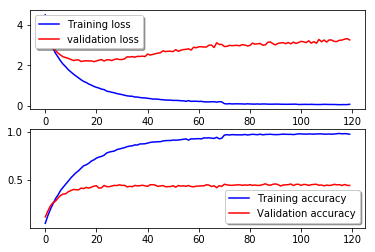

In [42]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(inception_history)

## Xception

best train accuracy 0.9969302554027505 on epoch 81 
best validation accuracy 0.5021766169154229 on epoch 66 
lowest train loss 0.6981174510213856 on epoch 105 
lowest validation loss 2.1028375922150873 on epoch 14 
saved accuracy : 0.8094302554027505, val accuracy : 0.46050995024875624, and train loss 0.6981174510213856 : 


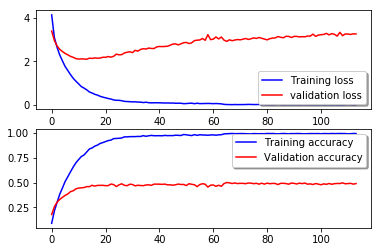

In [43]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(xception_history)

## Resnet50

best train accuracy 0.9930009823182712 on epoch 86 
best validation accuracy 0.5792910447761194 on epoch 86 
lowest train loss 0.44064327190339214 on epoch 108 
lowest validation loss 1.6824185883820946 on epoch 18 
saved accuracy : 0.8816306483300589, val accuracy : 0.5578358208955224, and train loss 0.44064327190339214 : 


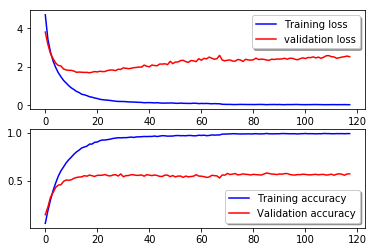

In [44]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(resnet_history)

## VGG19

best train accuracy 0.9901768172888016 on epoch 96 
best validation accuracy 0.5314054726368159 on epoch 86 
lowest train loss 0.9310862179589412 on epoch 96 
lowest validation loss 2.027386660006509 on epoch 8 
saved accuracy : 0.7278978388998035, val accuracy : 0.4894278606965174, and train loss 0.9310862179589412 : 


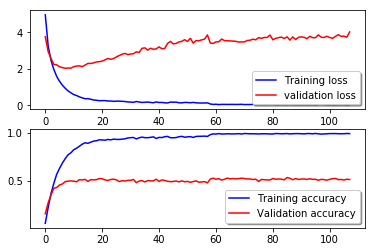

In [45]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(vgg_history)

## InceptionResnet_V2

best train accuracy 0.9722495088408645 on epoch 111 
best validation accuracy 0.49968905472636815 on epoch 120 
lowest train loss 1.097269080476817 on epoch 120 
lowest validation loss 2.1947048991473754 on epoch 23 
saved accuracy : 0.668467583497053, val accuracy : 0.42506218905472637, and train loss 1.097269080476817 : 


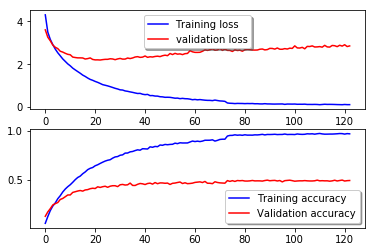

In [46]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(inceptionresnet_history)

# 3.4 Ensemble models

After fitting and eevaluating the models, now we ensemble all the models. 

### Load models with the highest accuracy results

In [47]:
from keras.models import load_model

inception_best = 'saved_models/inception.best.from_features.hdf5'
xception_best = 'saved_models/xception.best.from_features.hdf5'
resnet_best = 'saved_models/resnet.best.from_features.hdf5'
vgg_best = 'saved_models/vgg.best.from_features.hdf5'
inceptionresnet_best = 'saved_models/inceptionresnet.best.from_features.hdf5'

### Create Data sets for Ensemble model

In [48]:
incept = load_model(inception_best)
xcept = load_model(xception_best)
rest = load_model(resnet_best)
vg = load_model(vgg_best)
incres = load_model(inceptionresnet_best)

In [49]:
inc = incept.predict(inception_train_features, batch_size=32, verbose=0)
xce = xcept.predict(xception_train_features, batch_size=32, verbose=0)
res = rest.predict(resnet_train_features, batch_size=32, verbose=0)
vgg = vg.predict(vgg_train_features, batch_size=32, verbose=0)
incs = incres.predict(inceptionresnet_train_features, batch_size=32, verbose=0)


ensemble_train_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

In [50]:
print(ensemble_train_features.shape)

(8144, 980)


In [51]:
inc = incept.predict(inception_test_features, batch_size=32, verbose=0)
xce = xcept.predict(xception_test_features, batch_size=32, verbose=0)
res = rest.predict(resnet_test_features, batch_size=32, verbose=0)
vgg = vg.predict(vgg_test_features, batch_size=32, verbose=0)
incs = incres.predict(inceptionresnet_test_features, batch_size=32, verbose=0)


ensemble_test_features = np.concatenate((inc,xce,res,vgg,incs), axis = 1)

In [52]:
print(ensemble_test_features.shape)

(8041, 980)


In [53]:
ensemble_valid_x, ensemble_test_x, ensemble_valid_y, ensemble_test_y = train_test_split(ensemble_test_features, y_test, test_size=0.6, random_state=99)

## If you want to test the ensemble model, skip this training part below and move to Section 4

In [54]:
ensemble_model = Sequential()
ensemble_model.add(Dense(1024, activation='relu', input_shape= ensemble_train_features.shape[1:]))
ensemble_model.add(Dropout(0.5))
ensemble_model.add(Dense(512, activation='relu'))
ensemble_model.add(Dropout(0.2))
ensemble_model.add(Dense(n_class, activation='softmax'))

ensemble_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
           )

ensemble_model.summary()

ensemble_callbacks=[TQDMNotebookCallback(),
                     reduce_lr,
                      ModelCheckpoint(filepath='saved_models/ensemble.best.from_features.hdf5', 
                               verbose=1, save_best_only=True),
                     early_stopping
                     ]

ensemble_history = ensemble_model.fit(ensemble_train_features, y_train, 
                        validation_data=(ensemble_valid_x, ensemble_valid_y),
                        epochs=1000, 
                        callbacks=ensemble_callbacks,
                        class_weight=class_weights,
                        batch_size=32, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              1004544   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 196)               100548    
Total params: 1,629,892
Trainable params: 1,629,892
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 1.55636, saving model to saved_models/ensemble.best.from_features.hdf5



Epoch 00002: val_loss improved from 1.55636 to 1.50945, saving model to saved_models/ensemble.best.from_features.hdf5



Epoch 00003: val_loss did not improve from 1.50945



Epoch 00004: val_loss did not improve from 1.50945



Epoch 00005: val_loss did not improve from 1.50945



Epoch 00006: val_loss did not improve from 1.50945



Epoch 00007: val_loss did not improve from 1.50945



Epoch 00008: val_loss did not improve from 1.50945



Epoch 00009: val_loss did not improve from 1.50945



Epoch 00010: val_loss did not improve from 1.50945



Epoch 00011: val_loss did not improve from 1.50945



Epoch 00012: val_loss did not improve from 1.50945



Epoch 00013: val_loss did not improve from 1.50945



Epoch 00014: val_loss did not improve from 1.50945



Epoch 00015: val_loss did not improve from 1.50945



Epoch 00016: val_loss did not improve from 1.50945



Epoch 00017: val_loss did not improve from 1.50945



Epoch 00018: val_loss did not improve from 1.50945



Epoch 00019: val_loss did not improve from 1.50945



Epoch 00020: val_loss did not improve from 1.50945



Epoch 00021: val_loss did not improve from 1.50945



Epoch 00022: val_loss did not improve from 1.50945



Epoch 00023: val_loss did not improve from 1.50945



Epoch 00024: val_loss did not improve from 1.50945



Epoch 00025: val_loss did not improve from 1.50945



Epoch 00026: val_loss did not improve from 1.50945



Epoch 00027: val_loss did not improve from 1.50945



Epoch 00028: val_loss did not improve from 1.50945



Epoch 00029: val_loss did not improve from 1.50945



Epoch 00030: val_loss did not improve from 1.50945



Epoch 00031: val_loss did not improve from 1.50945



Epoch 00032: val_loss did not improve from 1.50945



Epoch 00033: val_loss did not improve from 1.50945



Epoch 00034: val_loss did not improve from 1.50945



Epoch 00035: val_loss did not improve from 1.50945



Epoch 00036: val_loss did not improve from 1.50945



Epoch 00037: val_loss did not improve from 1.50945



Epoch 00038: val_loss did not improve from 1.50945



Epoch 00039: val_loss did not improve from 1.50945



Epoch 00040: val_loss did not improve from 1.50945



Epoch 00041: val_loss did not improve from 1.50945



Epoch 00042: val_loss did not improve from 1.50945



Epoch 00043: val_loss did not improve from 1.50945



Epoch 00044: val_loss did not improve from 1.50945



Epoch 00045: val_loss did not improve from 1.50945



Epoch 00046: val_loss did not improve from 1.50945



Epoch 00047: val_loss did not improve from 1.50945



Epoch 00048: val_loss did not improve from 1.50945



Epoch 00049: val_loss did not improve from 1.50945



Epoch 00050: val_loss did not improve from 1.50945



Epoch 00051: val_loss did not improve from 1.50945



Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00052: val_loss did not improve from 1.50945



Epoch 00053: val_loss did not improve from 1.50945



Epoch 00054: val_loss did not improve from 1.50945



Epoch 00055: val_loss did not improve from 1.50945



Epoch 00056: val_loss did not improve from 1.50945



Epoch 00057: val_loss did not improve from 1.50945



Epoch 00058: val_loss did not improve from 1.50945



Epoch 00059: val_loss did not improve from 1.50945



Epoch 00060: val_loss did not improve from 1.50945



Epoch 00061: val_loss did not improve from 1.50945



Epoch 00062: val_loss did not improve from 1.50945



Epoch 00063: val_loss did not improve from 1.50945



Epoch 00064: val_loss did not improve from 1.50945



Epoch 00065: val_loss did not improve from 1.50945



Epoch 00066: val_loss did not improve from 1.50945



Epoch 00067: val_loss did not improve from 1.50945



Epoch 00068: val_loss did not improve from 1.50945



Epoch 00069: val_loss did not improve from 1.50945



Epoch 00070: val_loss did not improve from 1.50945



Epoch 00071: val_loss did not improve from 1.50945



Epoch 00072: val_loss did not improve from 1.50945



Epoch 00073: val_loss did not improve from 1.50945



Epoch 00074: val_loss did not improve from 1.50945



Epoch 00075: val_loss did not improve from 1.50945



Epoch 00076: val_loss did not improve from 1.50945



Epoch 00077: val_loss did not improve from 1.50945



Epoch 00078: val_loss did not improve from 1.50945



Epoch 00079: val_loss did not improve from 1.50945



Epoch 00080: val_loss did not improve from 1.50945



Epoch 00081: val_loss did not improve from 1.50945



Epoch 00082: val_loss did not improve from 1.50945



Epoch 00083: val_loss did not improve from 1.50945



Epoch 00084: val_loss did not improve from 1.50945



Epoch 00085: val_loss did not improve from 1.50945



Epoch 00086: val_loss did not improve from 1.50945



Epoch 00087: val_loss did not improve from 1.50945



Epoch 00088: val_loss did not improve from 1.50945



Epoch 00089: val_loss did not improve from 1.50945



Epoch 00090: val_loss did not improve from 1.50945



Epoch 00091: val_loss did not improve from 1.50945



Epoch 00092: val_loss did not improve from 1.50945



Epoch 00093: val_loss did not improve from 1.50945



Epoch 00094: val_loss did not improve from 1.50945



Epoch 00095: val_loss did not improve from 1.50945



Epoch 00096: val_loss did not improve from 1.50945



Epoch 00097: val_loss did not improve from 1.50945



Epoch 00098: val_loss did not improve from 1.50945



Epoch 00099: val_loss did not improve from 1.50945



Epoch 00100: val_loss did not improve from 1.50945



Epoch 00101: val_loss did not improve from 1.50945



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00102: val_loss did not improve from 1.50945

Epoch 00102: early stopping


best train accuracy 0.9985265225933202 on epoch 59 
best validation accuracy 0.6682213930348259 on epoch 9 
lowest train loss 0.05180998930564856 on epoch 84 
lowest validation loss 1.509454089610731 on epoch 2 
saved accuracy : 0.9906679764243614, val accuracy : 0.6551616915422885, and train loss 0.05180998930564856 : 


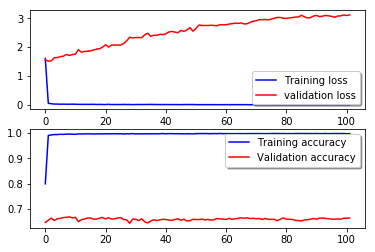

In [55]:
#Retrieve some information best train accuracy, validation accuracy, train loss and validation loss
model_evaluation(ensemble_history)

# 4. Testing model's performance

## 4.1 Confusion Matrix, Precision-Recall, AUC ROC Curve

Confusion matrix can check false positives for each labels. This can visualize bias and variance of the model's prediction.

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. See [HERE](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) for more info.

I validate the models using Test data.

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [78]:
def test_model(model_name, X_test, Y_test):

    # Look at confusion matrix 

    # Predict the values from the validation dataset
    Y_pred = model_name.predict(X_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_test,axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    ax = sns.heatmap(confusion_mtx)

    #Calculating Precision-Recall Score

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(196):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        Y_pred[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], Y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        Y_pred.ravel())
    average_precision["micro"] = average_precision_score(Y_test, Y_pred,
                                                     average="micro")

    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

    #Calculating ROC AUC Score

    roc_score = roc_auc_score(Y_test, Y_pred)

    print("ROC AUC Score: ", roc_score)

### InceptionV3

Average precision score, micro-averaged over all classes: 0.44
ROC AUC Score:  0.97922341696268


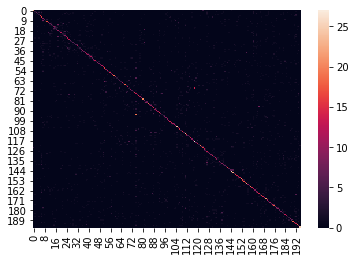

In [79]:
test_model(incept, X_test_inception, y_test_inception)

### Xception

Average precision score, micro-averaged over all classes: 0.48
ROC AUC Score:  0.9820504682842365


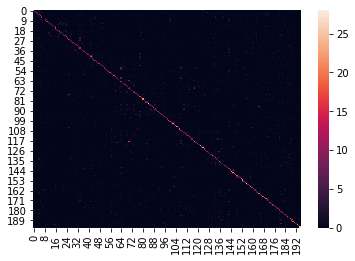

In [80]:
test_model(xcept, X_test_xception, y_test_xception)

### Resnet50

Average precision score, micro-averaged over all classes: 0.60
ROC AUC Score:  0.9881296592660188


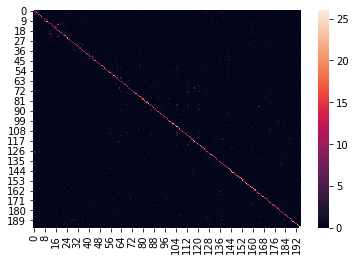

In [81]:
test_model(rest, X_test_resnet, y_test_resnet)

### VGG19

Average precision score, micro-averaged over all classes: 0.50
ROC AUC Score:  0.9804590379186605


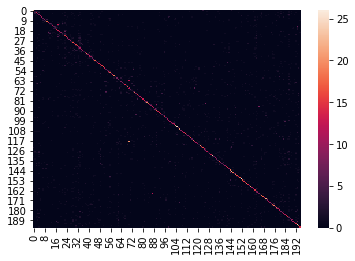

In [82]:
test_model(vg, X_test_vgg, y_test_vgg)

## InceptionResnetV2

Average precision score, micro-averaged over all classes: 0.44
ROC AUC Score:  0.9777620327419986


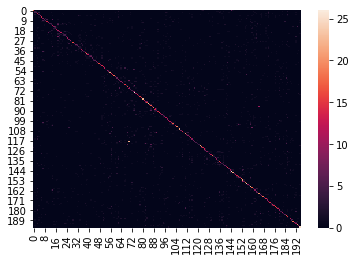

In [83]:
test_model(incres, X_test_inceptionresnet, y_test_inceptionresnet)

## Ensemble Model - The Final Model

In [86]:
# Load best saved model for ensemble model

ensemble = load_model("saved_models/ensemble.best.from_features.hdf5")

Average precision score, micro-averaged over all classes: 0.71
ROC AUC Score:  0.982546948446516


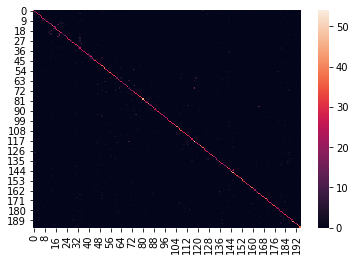

In [88]:
test_model(ensemble, ensemble_test_features, y_test)

## 4.2 Results Summary

The results can be slightly change if we re-train the model

#### 1. Inception

*Classification Accuracy: 0.6966 (train), 0.4229 (validation)

*Loss error             : 1.2172 (train), 2.1878 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9790820458637852

#### 2. Xception

*Classification Accuracy: 0.8115 (train), 0.4652 (validation)

*Loss error             : 0.6989 (train), 2.1083 (validation)

*Average precision score, micro-averaged over all classes: 0.50

*ROC AUC Score:  0.9824882943932024

#### 3. Resnet50

*Classification Accuracy: 0.8886 (train), 0.5572 (validation)

*Loss error             : 0.4049 (train), 1.7131 (validation)

*Average precision score, micro-averaged over all classes: 0.59

*ROC AUC Score:  0.9869771002900094

#### 4. VGG19

*Classification Accuracy: 0.7349 (train), 0.4773 (validation)

*Loss error             : 0.8825 (train), 2.1087 (validation)

*Average precision score, micro-averaged over all classes: 0.48

*ROC AUC Score:  0.9796499374539075

#### 5. InceptionResnet

*Classification Accuracy: 0.6971 (train), 0.4344 (validation)

*Loss error             : 1.0177 (train), 2.2085 (validation)

*Average precision score, micro-averaged over all classes: 0.44

*ROC AUC Score:  0.9774902336172602

### 6. Ensemble Model

*Classification Accuracy: 0.9905 (train), 0.6576 (validation)

*Loss error             : 0.0490 (train), 1.5401 (validation)

*Average precision score, micro-averaged over all classes: 0.70

*ROC AUC Score:  0.9813272164290486




It shows that Ensemble Model obtained significant improvement over others